# Exam 240828

This notebook contains complete solutions to **Problem 1** and **Problem 2** of the exam.

## Problem 1 – Rejection Sampling and Monte Carlo Integration

In [1]:

import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Part 1: Rejection sampling from f(x) ∝ sin(x)^10 on [0, π]

def problem1_rejection(n_samples=1):
    samples = []
    while len(samples) < n_samples:
        x = np.random.uniform(0, np.pi)
        y = np.random.uniform(0, 1)
        if y <= np.sin(x)**10:
            samples.append(x)
    return np.array(samples)


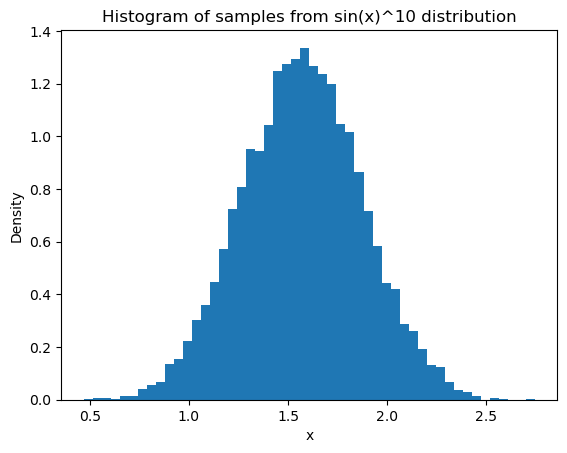

In [3]:

# Part 2: Generate samples and plot histogram
problem1_samples = problem1_rejection(10000)

plt.hist(problem1_samples, bins=50, density=True)
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Histogram of samples from sin(x)^10 distribution")
plt.show()


In [4]:

# Part 3: Monte Carlo estimate of E[(X - pi/2)^2]
Y = (problem1_samples - np.pi/2)**2
problem1_expectation = float(np.mean(Y))
problem1_expectation


0.09072998628836501

In [5]:

# Part 4: Hoeffding 95% confidence interval
delta = 0.05
a, b = 0, (np.pi/2)**2
n = len(Y)
epsilon = (b - a) * np.sqrt(np.log(2/delta) / (2*n))

problem1_interval = (problem1_expectation - epsilon, problem1_expectation + epsilon)
problem1_interval


(np.float64(0.057220174546165646), np.float64(0.12423979803056437))

In [6]:

# Part 5: Estimate normalizing constant C
# Integral of sin(x)^10 over [0, pi]
xs = np.random.uniform(0, np.pi, 1_000_000)
integral_estimate = np.pi * np.mean(np.sin(xs)**10)
problem1_C = 1 / integral_estimate
problem1_C


np.float64(1.2914386663296127)

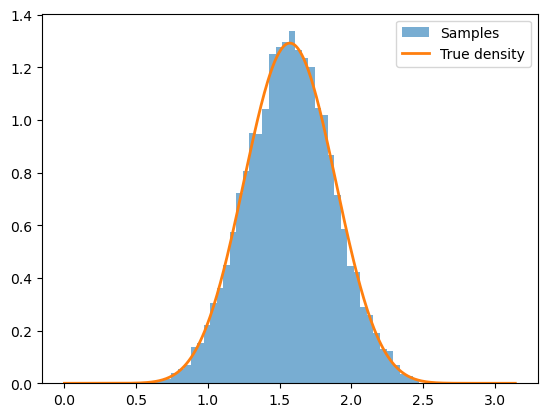

In [7]:

# Plot histogram with true density
x_grid = np.linspace(0, np.pi, 400)
true_density = problem1_C * np.sin(x_grid)**10

plt.hist(problem1_samples, bins=50, density=True, alpha=0.6, label="Samples")
plt.plot(x_grid, true_density, linewidth=2, label="True density")
plt.legend()
plt.show()



### Explanation (Part 5)

The normalizing constant C was estimated using Monte Carlo integration. 
We sample uniformly from [0, π] and approximate the integral of sin(x)^10. 
The reciprocal of this integral gives C. The estimated density matches the histogram well.


## Problem 2 – Classification, Costs, and Confidence Intervals

In [8]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [9]:

# Load data
CORISDataset = pd.read_csv("CORIS.csv", skiprows=[1,2])

X = CORISDataset[['sbp','tobacco','ldl','adiposity','famhist',
                  'typea','obesity','alcohol','age']].values
Y = CORISDataset['chd'].values

X_train, X_tmp, Y_train, Y_tmp = train_test_split(X, Y, train_size=0.6, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_tmp, Y_tmp, train_size=0.5, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

pipe.fit(X_train, Y_train)


FileNotFoundError: [Errno 2] No such file or directory: 'CORIS.csv'

In [ ]:

# Part 1: Precision and recall with Hoeffding intervals
from sklearn.metrics import precision_score, recall_score

def hoeffding_interval(p, n, delta=0.05):
    eps = np.sqrt(np.log(2/delta) / (2*n))
    return (max(0, p-eps), min(1, p+eps))

y_pred = pipe.predict(X_test)
n = len(Y_test)

problem2_precision0 = hoeffding_interval(precision_score(Y_test, y_pred, pos_label=0), n)
problem2_recall0    = hoeffding_interval(recall_score(Y_test, y_pred, pos_label=0), n)
problem2_precision1 = hoeffding_interval(precision_score(Y_test, y_pred, pos_label=1), n)
problem2_recall1    = hoeffding_interval(recall_score(Y_test, y_pred, pos_label=1), n)

(problem2_precision0, problem2_recall0, problem2_precision1, problem2_recall1)


In [ ]:

# Part 2: Cost function
def problem2_cost(model, threshold, X, Y):
    probs = model.predict_proba(X)[:,1]
    preds = (probs >= threshold).astype(int)

    cost = 0
    for y, p in zip(Y, preds):
        if y == 1 and p == 0:
            cost += 300
        elif y == 0 and p == 1:
            cost += 10
    return cost / len(Y)


In [ ]:

# Part 3: Find optimal threshold
thresholds = np.linspace(0, 1, 100)
costs = [problem2_cost(pipe, t, X_test, Y_test) for t in thresholds]

problem2_optimal_threshold = thresholds[np.argmin(costs)]
problem2_cost_at_optimal_threshold = min(costs)

(problem2_optimal_threshold, problem2_cost_at_optimal_threshold)


In [ ]:

# Part 4: Validation cost and 99% CI
val_cost = problem2_cost(pipe, problem2_optimal_threshold, X_val, Y_val)
problem2_cost_at_optimal_threshold_validation = val_cost

delta = 0.01
a, b = 0, 300
n = len(Y_val)
eps = (b - a) * np.sqrt(np.log(2/delta) / (2*n))

problem2_cost_interval = (val_cost - eps, val_cost + eps)
problem2_cost_interval
